# Regression Models with Categorical Variables

## Data Science 410

Up to now, we have only worked with **numeric variables**. However, **categorical variables** are extremely common. In fact, most real-world data science problems involve one or more categorical variables. Indeed, some types of analysis involve only categorical variables. For examine, in natural language processing, all variables are categorical in the form of words or phrases. 

Machine learning problems can have categorical variables as features. Classification problems have categorical labels, and the goal is to predict the category. 

In this notebook you will be introduced to working with categorical variables in regression models. The methods explored apply to most any machine learning model.  

## Preparing the Data Set

In this section we will prepare the data set we will use in this notebook. As a first step, execute the code in the cell below to import the required packages.

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import statsmodels.api as sm
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices

%matplotlib inline

Execute the cell below to perform the following operations:     
- Load the dataset into a data frame.
- Compute some features for the model.
- Scale the numeric features. 
- Create a data frame of the features. 

In [2]:
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

gaulton = pd.read_csv('GaltonFamilies.csv')

gaulton.loc[:,'mother_sqr'] = np.square(gaulton.loc[:,'mother'])
gaulton.loc[:,'father_sqr'] = np.square(gaulton.loc[:,'father'])

for col in ['mother','father', 'mother_sqr','father_sqr']:
    gaulton.loc[:,col] = scale(gaulton.loc[:,col])
    
gaulton.head()

,Unnamed: 0,family,father,mother,midparentHeight,children,childNum,gender,childHeight,mother_sqr,father_sqr
0,1,1,3.758511,1.271240,75.43,4,1,male,73.2,1.288806,3.982166
1,2,1,3.758511,1.271240,75.43,4,2,female,69.2,1.288806,3.982166
2,3,1,3.758511,1.271240,75.43,4,3,female,69.0,1.288806,3.982166
3,4,1,3.758511,1.271240,75.43,4,4,female,69.0,1.288806,3.982166
4,5,2,2.546465,1.052867,73.66,4,1,male,73.5,1.060203,2.637197


There are a number of numeric variables and one categorical variable, gender. 

## Categorical Variables and the Model Matrix

Most machine learning models can only work with numeric variables. Therefore, ee need to encode the categorical variables into one or more numeric variables. The common approach is to convert the categorical variable to a set of binary **dummy variables** or **indicator variables**. 

We will work with the Python [patsy](https://patsy.readthedocs.io/en/latest/quickstart.html) package which creates **design matrices** from Pandas data frames. Patsy creates the design matrices using the, by now familiar, R-style modeling language. These design matrices can be used directly in statsmodels or scikit-learn models. 

> **Note:** In this lesson we will use the term design matrices. However, you often see the term **model matrices**. Don't be confused! These terms mean the same thing.

### Dealing with the Intercept Term

To start our exploration of how model matrices are constructed we will start with an example using only numeric variables. We will use the [dmatrices](https://patsy.readthedocs.io/en/latest/API-reference.html) function from the patsy package, which returns both the feature and label matrices. Execute the code in the cell below to construct the label and design matrices for the model formula shown and examine the results. 

In [3]:
y, X = dmatrices('childHeight ~ mother + father + mother_sqr + father_sqr', data=gaulton)
print('Head of label matrix \n{}\n'.format(y[:5]))
print('Design matrix \n{}'.format(X[:5]))

Head of label matrix 
[[73.2]
 [69.2]
 [69. ]
 [69. ]
 [73.5]]

Design matrix 
[[1.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         1.05286687 2.54646489 1.06020301 2.6371972 ]]


The label matrix, $y$, looks much as you might expect. A one dimensional array of label values.  

The columns of the feature matrix might surprise you. There are 4 columns containing the scaled values of the 4 features. But, notice that the first column is all 1's. This is the feature column for the **intercept term**.

We may not always want an intercept term. The [formulas](https://patsy.readthedocs.io/en/latest/formulas.html) use used by pasty allow you to construct design matrices without an intercept by including -1 the formula. The code in the cell below does just this. Execute this code and examine the result.  

In [4]:
y, X = dmatrices('childHeight ~ mother + father + mother_sqr + father_sqr - 1', data=gaulton)
print('Head of label matrix \n{}\n'.format(y[:5]))
print('Design matrix \n{}'.format(X[:5]))

Head of label matrix 
[[73.2]
 [69.2]
 [69. ]
 [69. ]
 [73.5]]

Design matrix 
[[1.27123996 3.75851106 1.28880581 3.98216579]
 [1.27123996 3.75851106 1.28880581 3.98216579]
 [1.27123996 3.75851106 1.28880581 3.98216579]
 [1.27123996 3.75851106 1.28880581 3.98216579]
 [1.05286687 2.54646489 1.06020301 2.6371972 ]]


The feature matrix no longer has a column of 1s. A model computed using these design matrices will not have an intercept term.  

### Design Matrices with Categorical Variables

We are now ready to create design matrices including the [coding of categorical features](https://patsy.readthedocs.io/en/latest/categorical-coding.html) using patsy. The code in the cell below includes the single binary categorical feature, gender, in the model formula. Execute this code and examine the result. 

In [5]:
y, X = dmatrices('childHeight ~ mother + father + mother_sqr + father_sqr + gender', data=gaulton)
print('Head of label matrix \n{}\n'.format(y[:5]))
print('Design matrix \n{}'.format(X[:5]))

Head of label matrix 
[[73.2]
 [69.2]
 [69. ]
 [69. ]
 [73.5]]

Design matrix 
[[1.         1.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         0.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         0.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         0.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         1.         1.05286687 2.54646489 1.06020301 2.6371972 ]]


There is now a binary feature column in the feature matrix, representing gender. By comparing the coding to the original data frame you can see that 1 codes male and 0 codes female. 

**Your Turn 1:** What happens when you choose not to have an intercept term in a model formula. To find out create label and design matrices using the same formula as above (including the categorical variable), but including a -1. 

In [6]:
y, X = dmatrices('childHeight ~ mother + father + mother_sqr + father_sqr + gender - 1', data=gaulton)
print('Head of label matrix \n{}\n'.format(y[:5]))
print('Design matrix \n{}'.format(X[:5]))

Head of label matrix 
[[73.2]
 [69.2]
 [69. ]
 [69. ]
 [73.5]]

Design matrix 
[[0.         1.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         0.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         0.         1.27123996 3.75851106 1.28880581 3.98216579]
 [1.         0.         1.27123996 3.75851106 1.28880581 3.98216579]
 [0.         1.         1.05286687 2.54646489 1.06020301 2.6371972 ]]


Notice that the first two columns of the feature matrix are now binary variables. Comparing the coding to the original data frame you can see that the first column codes for female and the second binary column for male. Notice also, that if one of these columns is coded as 1 the other is coded as 0 or vice versa. 

But, what happens to the intercept term in our model? The model parameter values estimated for these columns will include the intercept term. IN effect there is an intercept for each level of the categorical variable. In this case, the parameter values for the first two columns will be:

\begin{align}
b_{female} &= female\ intercept \\
b_{male} &= male\ intercept
\end{align}

What happens when we have $k$ levels in a categorical variable? In this case, the design matrix will include $k-1$ indicator variable columns. However, if no intercept is included, there will be $k$ indicator variable columns for the first categorical variable coded to account for the intercept, and number of levels $-1$ indicator variable columns code the other categorical variables. These rules can be a bit confusing at first. Some additional examples are provided in the patsy documentation. 

## Regression Model with Design Matrices

Now that you have created label and design matrices its time to compute a regression model. The code in the cell below, creates a ordinary lest squares regression model using the design matrices, and then prints a summary. The code uses the [statsmodels.regression.linear_model.OLS](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html) function to define the model object. This model takes the label and design matrices as arguments. 

Execute this code and examine the model summary. 

In [7]:
reg_model = sm.OLS(y, X).fit(method='pinv') 
reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            childHeight   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     324.1
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          1.04e-200
Time:                        09:41:37   Log-Likelihood:                -2044.0
No. Observations:                 934   AIC:                             4100.
Df Residuals:                     928   BIC:                             4129.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
gender[female]    64.0561      0.102    628.139      0.000      63.856      64.256
gender[male]      69.2792      0.099    700.126      0.000      69.085      69.473
mother            -1.0503      2.778     -0.378      0.705      -6.502       4.401
father            -1.0336      2.505     -0.413      0.680      -5.950       3.883
mother_sqr         1.7751      2.778      0.639      0.523      -3.678       7.228
father_sqr         2.0040      2.506      0.800      0.424      -2.914       6.922
==============================================================================
Omnibus:                       11.029   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               15.037
Skew:                          -0.118   Prob(JB):                     0.000543
Kurtosis:                       3.575   Cond. No.                         81.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Examine the model summary and answer the following questions. 
1. Which model parameters are statistically significant? 
2. How can you interpret the values of these significant parameters?   

## Logistic Regression

Until now, we have been working strictly with linear regression models. Linear regression models have a numeric label. Further, ordinary linear regression assumes the label values are Normally distributed. 

But, what if the label has another distribution, particularly if the label is categorical? Using a more general form for the label values leads us to the **generalized linear model**. Generalized linear model can use a number of distributions for the label .   

Here, we will look at a widely used variation of the generalized linear model using a **Binomial distribution**. This method is commonly known as **logistic regression**.

Logistic regression is widely used as a classification model. Logistic regression is linear model, with a binary response or label values, `{False, True}` or `{0, 1}`.  specifically, the response is computed as a log likelihood, leading to a Binomial distribution of the label values. 

The response of the linear model is transformed to the log likelihood using a sigmoidal function, also know as the **logistic function** or **logit**:

$$f(x) = \frac{1}{1 + e^{-\kappa(x - x_0)}} \\
\kappa = steepness$$

Execute the code in the cell below to compute and plot an example of the logistic function.

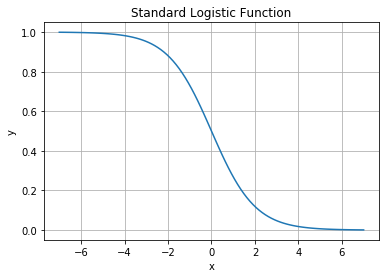

In [8]:
# Plot the logistic transformation function (f(x) above)
x_seq = np.linspace(-7, 7, 100)

def log_fun(x, center=0, scale=1):
    e = np.exp(-scale*(x-center))
    log_out = 1./(1. + e)
    return log_out

log_fun_vectorized = np.vectorize(log_fun)

log_y = log_fun_vectorized(x_seq)

plt.plot(x_seq, log_y)
plt.title('Standard Logistic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

Let's make this a bit more concrete with a simple example. Say we have a linear model:

$$\hat{y} = \beta_0 + \beta_1\ x$$

Now, depending on the value of $\hat{y}$ we want to classify the output from a logistic regression model as either `0` or `1`. We can use the linear model in the logistic function as follows:

$$F(\hat{y}) = \frac{1}{1 + e^{-\kappa(\beta_0 + \beta_1\ x)}} $$

In this way we transform the continious output of the linear model defined on $-\infty \le \hat{y} \le \infty$ to a binary response, $0 \le F(\hat{y}) \le 1$

The aforementioned function maps the output of a linear model to the response values of the label. This function is known as the **link function**, since it links the linear response to the label values.  

### Classification Example

Next, we will try to classify the gender of the children in the Gaulton families data set using logistic regression on the height data.

As a first step, you must need to create the label and design matrices, with scaled features, by executing the code in the cell below. 

In [9]:
gaulton.loc[:,'childHeight'] = scale(gaulton.loc[:,'childHeight']) # First scale the childHeight column

y, X = dmatrices('gender ~ mother + father + childHeight', data=gaulton)
print('Head of label matrix \n{}\n'.format(y[:5]))
print('Design matrix \n{}'.format(X[:5]))

Head of label matrix 
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]

Design matrix 
[[1.         1.27123996 3.75851106 1.80415568]
 [1.         1.27123996 3.75851106 0.68600475]
 [1.         1.27123996 3.75851106 0.6300972 ]
 [1.         1.27123996 3.75851106 0.6300972 ]
 [1.         1.05286687 2.54646489 1.88801699]]


The feature (design) matrix is not surprising, it contains the intercept term and the three scaled features. The label matrix using two dummy variables to encode female and male. 

The statsmodels [GLM](https://www.statsmodels.org/stable/examples/notebooks/generated/glm.html) function implements the [generalize linear model](https://www.statsmodels.org/stable/glm.html#families) for a number of response distributions. The code in the cell below uses the Binomial family as the distribution of the label.

Now, fit the model and print the summary by executing the code in the cell below. 

In [10]:
glm_model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
glm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Generalized Linear Model Regression Results                          
==============================================================================================
Dep. Variable:     ['gender[female]', 'gender[male]']   No. Observations:                  934
Model:                                            GLM   Df Residuals:                      930
Model Family:                                Binomial   Df Model:                            3
Link Function:                                  logit   Scale:                          1.0000
Method:                                          IRLS   Log-Likelihood:                -253.74
Date:                                Tue, 07 Apr 2020   Deviance:                       507.49
Time:                                        09:41:37   Pearson chi2:                 2.79e+03
No. Iterations:                                     7                                         
Covariance Type:                            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2584      0.116     -2.237      0.025      -0.485      -0.032
mother          0.8169      0.123      6.651      0.000       0.576       1.058
father          1.0900      0.130      8.374      0.000       0.835       1.345
childHeight    -3.8926      0.255    -15.259      0.000      -4.393      -3.393
===============================================================================
"""

Examine the summary of the model noticing the following:    
- The distribution family of the label is Binomial as expected. 
- The **link function** is the logit. The link function transforms the results of the linear model label to the label distribution. 
- The Pearson Chi Squared statistic shows that the model is significant compared to a null model based on the difference in deviance.   
- The standard errors and t-test results show that all the features are significant. 

### What is Deviance?

The significance of the GLM is expressed in terms of something called **deviance**. It can be a bit of a challenge to wrap your head around what deviance really means. It turns out that you already know one form of deviance. The familiar mean squared error of a model with Normally distributed residuals is the deviance of this model.  

For the model above the residuals would be Binomially distributed. We need a more general formulation of deviance for such a model. For a model with label vector $y$, predictions$\hat{\mu}$, and estimated model parameters, $\hat{\theta}$ the general form of deviance can be written:

\begin{align}
D(y,\hat{\mu}) &= 2 \Big( log \big( p(y | \hat{\theta}_{S}) \big) - log \big( p(y | \hat{\theta}_{0}) \big) \Big) \\
&= 2 \Big( \mathcal{l}(y | \hat{\theta}_{S})  -  \mathcal{l}(y | \hat{\theta}_{0})  \Big)
\end{align}

where,    
- $\mathcal{l}(y | \hat{\theta}) \big)$ is the log likelihood of a model with estimated parameters, $\hat{\theta}$, given labels $y$.    
- $\hat{\theta}_{S}$ are the estimated parameters of a **saturated**; a hypothetical model, $M_S$, with a parameter for each observation, and therefore having the best possible fit to the training data.   
- $\hat{\theta}_{0}$ are the actual estimated parameters of the model, $M_0$, that we wish to evaluate.   

This all seems rather abstract. In particular, what use is this hypothetical saturated model? 

Fortunately, we can use the **deviance ratio** to compare models in a form we can actually work with. The trick is to recognize that the log likelihood of the saturated model, $\mathcal{l}(y | \hat{\theta}_{0})$, is just a constant. With this insight we can rewrite the deviance as:

$$D(y,\hat{\mu}) = Constant + 2 \mathcal{l}(y | \hat{\theta}_{0})$$

This looks a bit better! Now we can work with the deviance ratio to compare two models, $M_1$ and $M_0$:   

\begin{align}
D(\hat{\theta}_1,\hat{\theta}_0) &= \frac{Constant + 2 \mathcal{l}(y | \hat{\theta}_{0})}{Constant + 2 \mathcal{l}(y | \hat{\theta}_{1})} \\ 
&= Constant + 2 \mathcal{l}(y | \hat{\theta}_{0}) - Constant - 2 \mathcal{l}(y | \hat{\theta}_{1}) \\
&= 2 \mathcal{l}(y | \hat{\theta}_{0}) - 2 \mathcal{l}(y | \hat{\theta}_{1})
\end{align}

Which model should we use as a comparison in the above relation? The **null model** is a good choice. The null model is just a model that makes predictions based on the expected value of mean. This formulation is called the **null deviance**, and is what is typically displayed by most statistical software packages, including statsmodels. Unfortunately, this quantity is usually just called, deviance, even when it is actually null deviance, something rather different.   

A nice property of null deviance is that for large number of samples (approaching infinity), it is Chi Squared distributed. Thus, we can test the statistical significance of the model against the null model using the Chi Squared test. Since the derivation of this test depends on something called Wilk's theorem, this is often referred to as **Wilk's test**. 

The null deviance is also useful for comparing models. If you have two models and want to know which is better, pick the one with the maximum null deviance.  

### From Probability to Class

The output of our predictions is a probability.  In order to make this a binary prediction (Female or male), we need to decide a cutoff.  Commonly, we choose 0.5 as a cutoff.  But know that this choice is arbitrary and we can set it to whatever probability we choose.  If we have a model where False Positives are costly, we might decide to increase the cutoff, and vice-versa if False Negatives are more costly. 

Execute the code in the cell below to transform the probabilities to female and male categories. 

In [11]:
threshold = 0.5
gaulton.loc[:,'prediction_probs'] = glm_model.predict(X)
gaulton['predicted'] = 'male'
gaulton.loc[np.where(gaulton.loc[:,'prediction_probs'] > threshold)[0].tolist(),'predicted'] = 'female'

gaulton.head(10)

,Unnamed: 0,family,father,mother,midparentHeight,children,childNum,gender,childHeight,mother_sqr,father_sqr,prediction_probs,predicted
0,1,1,3.758511,1.271240,75.43,4,1,male,1.804156,1.288806,3.982166,0.104709,male
1,2,1,3.758511,1.271240,75.43,4,2,female,0.686005,1.288806,3.982166,0.900832,female
2,3,1,3.758511,1.271240,75.43,4,3,female,0.630097,1.288806,3.982166,0.918649,female
3,4,1,3.758511,1.271240,75.43,4,4,female,0.630097,1.288806,3.982166,0.918649,female
4,5,2,2.546465,1.052867,73.66,4,1,male,1.888017,1.060203,2.637197,0.018489,male
5,6,2,2.546465,1.052867,73.66,4,2,male,1.608479,1.060203,2.637197,0.052961,male
6,7,2,2.546465,1.052867,73.66,4,3,female,-0.348285,1.060203,2.637197,0.991277,female
7,8,2,2.546465,1.052867,73.66,4,4,female,-0.348285,1.060203,2.637197,0.991277,female
8,9,3,2.344457,-0.038999,72.06,2,1,male,1.189173,-0.057125,2.418130,0.085978,male
9,10,3,2.344457,-0.038999,72.06,2,2,female,0.350559,-0.057125,2.418130,0.711070,female


We are also interested in evaluating our classifier's accuracy.  Here we will look at how many are:

 - True Positives (TP): We predicted Female and the actual gender was Female.
 - True Negatives (TN): We predicted Male and the actual gender was Male.
 - False Positives (FP): We predicted Female and the actual gender was Male.
 - False Negatives (FN): We predicted Male and the actual gender was Female.

The other metrics are defined as follows:

- Accuracy = (TP + TN) / (TP + FP + TN + FN)
- Precision = TP / (TP + FP)
   - Precision is the fraction of the relevant class predictions are actually correct.
- Recall = TP / (TP + FN)
   - Recall is the fraction of the relevant class were we able to predict.
   
Now, execute the code in the cell below to evaluate the performance of the classifier.    

In [12]:
TP = np.sum([a == 'female' and p == 'female' for a, p in zip(gaulton['gender'], gaulton['predicted'])])
TN = np.sum([a == 'male' and p == 'male' for a, p in zip(gaulton['gender'], gaulton['predicted'])])

FP = np.sum([a == 'male' and p == 'female' for a, p in zip(gaulton['gender'], gaulton['predicted'])])
FN = np.sum([a == 'female' and p == 'male' for a, p in zip(gaulton['gender'], gaulton['predicted'])])

num_obs = gaulton.shape[0]

print('Out of {} observations:'.format(num_obs))
print('TP: {}, FP: {}'.format(TP, FP))
print('FN: {}, TN: {}'.format(FN, TN))

accuracy = (TP + TN) / num_obs
print('\nAccuracy = : {}'.format(accuracy))

precision = TP/(TP + FP)
print('Precision = {}'.format(precision))

recall = TP / (TP + FN)
print('Precision = {}'.format(recall))

Out of 934 observations:
TP: 404, FP: 57
FN: 49, TN: 424

Accuracy = : 0.8865096359743041
Precision = 0.8763557483731019
Precision = 0.891832229580574


In the confusion matrix females are defined as Positive cases and males are Negative cases. Notice that most of the cases in this data are correctly classified with only a few false negatives and false positives.

The three summary statistics show the classifier works fairly well.

#### Copyright 2017, 2018, 2019, 2020 Stephen F Elston. All rights reserved. 